In [35]:
from keras.utils import np_utils
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from numpy import linalg as LA
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [117]:
img_list = []
y_list = []
for file in os.listdir("Cropped/"):
    yi = int(file.split('_')[0]) - 1 
#     image = cv2.imread("Cropped/"+ file)
# #     image = cv2.imread("Cropped/"+ file)
#     image = cv2.resize(image,(224,224))
    img = preprocess_image("Cropped/"+ file)[0,:]
    img_list.append(img)
    y_list.append(yi)
X = np.array(img_list)
y = np.array(y_list)

In [118]:
X.shape

(780, 224, 224, 3)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [218]:
y_train = y_train.reshape((-1, 1))

In [120]:
X_train.shape

(585, 224, 224, 3)

In [207]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(4096,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(195,activation='relu'))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))
for layer in model.layers[:30]:
    layer.trainable = False

In [177]:
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

In [208]:
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()

In [209]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(195, activation='relu'))

In [14]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [210]:
vgg_ear_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-1].output)

In [211]:
vgg_ear_descriptor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_196_input (In (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_196 (ZeroPadd (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_197 (ZeroPadd (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_198 (ZeroPadd (None, 114, 114, 64)      0         
__________

In [213]:
sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
vgg_ear_descriptor.compile(optimizer=sgd,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [217]:
y_train

(585,)

In [221]:
vgg_ear_descriptor.fit(X_train,y_train,epochs=1)

ValueError: Error when checking target: expected dense_26 to have shape (195,) but got array with shape (1,)

In [26]:
knowledges = []
ref = {}
i = 0
for file in os.listdir("Cropped/"):
    img_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (file)))[0,:]
    ref[i] = file.split('_')[0]
    knowledges.append(img_representation)
    i+=1

In [68]:
j = 0
ref = {}
for file in os.listdir("Cropped/"):
    ref[j] = (int)(file.split('_')[0])
    j+=1

In [69]:
ref

{0: 121,
 1: 164,
 2: 75,
 3: 130,
 4: 66,
 5: 23,
 6: 60,
 7: 160,
 8: 3,
 9: 188,
 10: 22,
 11: 103,
 12: 186,
 13: 84,
 14: 167,
 15: 79,
 16: 34,
 17: 44,
 18: 1,
 19: 171,
 20: 103,
 21: 146,
 22: 172,
 23: 72,
 24: 63,
 25: 111,
 26: 11,
 27: 126,
 28: 159,
 29: 139,
 30: 39,
 31: 18,
 32: 127,
 33: 144,
 34: 162,
 35: 44,
 36: 60,
 37: 25,
 38: 127,
 39: 138,
 40: 27,
 41: 180,
 42: 82,
 43: 59,
 44: 56,
 45: 156,
 46: 42,
 47: 7,
 48: 105,
 49: 140,
 50: 35,
 51: 18,
 52: 135,
 53: 48,
 54: 148,
 55: 107,
 56: 142,
 57: 40,
 58: 5,
 59: 79,
 60: 96,
 61: 81,
 62: 181,
 63: 184,
 64: 118,
 65: 62,
 66: 27,
 67: 125,
 68: 160,
 69: 192,
 70: 38,
 71: 80,
 72: 193,
 73: 93,
 74: 182,
 75: 80,
 76: 38,
 77: 151,
 78: 101,
 79: 144,
 80: 46,
 81: 14,
 82: 3,
 83: 59,
 84: 106,
 85: 43,
 86: 99,
 87: 110,
 88: 64,
 89: 21,
 90: 123,
 91: 166,
 92: 55,
 93: 179,
 94: 86,
 95: 147,
 96: 2,
 97: 184,
 98: 146,
 99: 191,
 100: 3,
 101: 91,
 102: 18,
 103: 111,
 104: 105,
 105: 140,
 106:

In [37]:
knowledges = np.array(knowledges)
y = np.arange(780)

In [30]:
knowledges.shape

(780, 2622)

In [38]:
y.shape

(780,)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(knowledges, y,test_size=0.2,random_state=50)

In [85]:
X_train.shape

(624, 2622)

In [101]:
dtype = [('distance', float), ('index', int)]
m = 0
acc = 0
for test in X_test:
    dist = []
    n = 0
    for train in X_train:
        dist.append((LA.norm(test - train),n))
        n+=1
    a = np.array(dist,dtype=dtype)
    a = np.sort(a,order='distance')[0:30]
    for each in a :
        if ref.get(each[1]) == ref.get(y[m]):
            acc+=1
    m+=1

In [80]:
a

array([(16.78728867, 213), (25.42363548, 460), (25.82349968, 369),
       (26.58436394, 322), (27.67225647, 342)],
      dtype=[('distance', '<f8'), ('index', '<i8')])

In [105]:
from scipy.spatial.distance import cosine

In [108]:
dtype = [('cos', float), ('index', int)]
m = 0
acc_cos = 0
for test in X_test:
    dist = []
    n = 0
    for train in X_train:
        dist.append((cosine(test,train),n))
        n+=1
    a = np.array(dist,dtype=dtype)
    a = np.sort(a,order='cos')[0:50]
    for each in a :
        if ref.get(each[1]) == ref.get(y[m]):
            acc+=1
    m+=1
print(acc_cos)

0


In [107]:
a

array([(0.03179526, 213), (0.07034123, 460), (0.07053202, 322),
       (0.07186782, 369), (0.07734919, 140), (0.07760042, 344),
       (0.08542949,  95), (0.08627975,  34), (0.08637601, 558),
       (0.08864999, 342), (0.08915257, 262), (0.09195572, 305),
       (0.09519541, 110), (0.09788543, 243), (0.09805852, 339),
       (0.1020422 ,  80), (0.10244071, 497), (0.10271412, 387),
       (0.10489291, 320), (0.10503322,  10)],
      dtype=[('cos', '<f8'), ('index', '<i8')])

In [21]:
epsilon = 0.20

def verifyEar(img1, img2):
    img1_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (img1)))[0,:]
    img2_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('Cropped/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('Cropped/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

Cosine similarity:  0.24004191160202026
Euclidean distance:  49.301937
unverified! they are not same person!


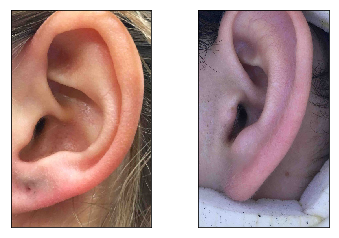

-----------------------------------------


In [23]:
verifyEar("001_.jpg", "005_dt.jpg")